In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pydataset import data
from datetime import date
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
from env import get_db_url, user, password, host
import acquire
import prepare
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

In [2]:
# Using titanic data:
# 1. What is your baseline prediction? What is your baseline accuracy? 

In [3]:
titanic = acquire.get_titanic_data()

Using cached csv


In [4]:
titanic = prepare.prep_titanic(titanic)

In [5]:
titanic.head()

,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,3,1,0,7.2500,0,1,0,1
1,1,1,1,0,71.2833,0,0,0,0
2,1,3,0,0,7.9250,1,0,0,1
3,1,1,1,0,53.1000,0,0,0,1
4,0,3,0,0,8.0500,1,1,0,1


In [6]:
titanic.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [7]:
# Our target value is 'survived' and the baseline is 0 (did not survive)

In [8]:
# added baseline too early
# titanic['baseline'] = 0

In [9]:
# 2. Fit the decision tree classifier to training sample and transform
# Create train, validate, test split of data

In [10]:
def train_validate_test_split(df, target, seed=123):
    '''
    - Takes in df, name of target variable, and integer for setting a seed
    - Splits the data into train, validate, and test
    - Test is 20% of original dataset, validate is .3 * .8 = 24%, train is .7 * .8 = 56% of original dataset
    - Function returns train, validate, test df
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state = seed, stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=.3, random_state=seed, stratify=train_validate[target])
    return train, validate, test

In [11]:
train, val, test = train_validate_test_split(titanic, 'survived')

In [12]:
train.shape, val.shape, test.shape

((498, 9), (214, 9), (179, 9))

In [13]:
train['baseline'] = 0

In [14]:
sklearn.metrics.accuracy_score(train.baseline, train.survived)

0.6164658634538153

In [15]:
# Need to make sure you do not carry the baseline forward, will change features and modeling accuracy
train.drop(columns='baseline', inplace=True)

In [16]:
# [dataset.drop(columns=drops, inplace=True) for dataset in [train, validate, test]]

In [17]:
x_train = train.drop(columns='survived')
y_train = train.survived

x_validate = val.drop(columns=['survived'])
y_validate = val.survived

x_test = test.drop(columns='survived')
y_test = test.survived

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [19]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [20]:
clf = clf.fit(x_train, y_train)

In [21]:
train.head()

,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
583,0,1,0,0,40.1250,1,1,0,0
165,1,3,0,2,20.5250,0,1,0,1
50,0,3,4,1,39.6875,0,1,0,1
259,1,2,0,1,26.0000,0,0,0,1
306,1,1,0,0,110.8833,1,0,0,0


[Text(362.7, 332.955, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]\nclass = not survived'),
 Text(181.35, 237.825, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]\nclass = survived'),
 Text(90.675, 142.695, 'fare <= 28.856\ngini = 0.081\nsamples = 94\nvalue = [4, 90]\nclass = survived'),
 Text(45.3375, 47.565, 'gini = 0.133\nsamples = 42\nvalue = [3, 39]\nclass = survived'),
 Text(136.0125, 47.565, 'gini = 0.038\nsamples = 52\nvalue = [1, 51]\nclass = survived'),
 Text(272.025, 142.695, 'fare <= 23.912\ngini = 0.498\nsamples = 81\nvalue = [38, 43]\nclass = survived'),
 Text(226.6875, 47.565, 'gini = 0.476\nsamples = 69\nvalue = [27, 42]\nclass = survived'),
 Text(317.3625, 47.565, 'gini = 0.153\nsamples = 12\nvalue = [11, 1]\nclass = not survived'),
 Text(544.05, 237.825, 'fare <= 18.275\ngini = 0.295\nsamples = 323\nvalue = [265, 58]\nclass = not survived'),
 Text(453.375, 142.695, 'parch <= 0.5\ngini = 0.184\nsamples = 205\nvalue = [184, 21]\nclass

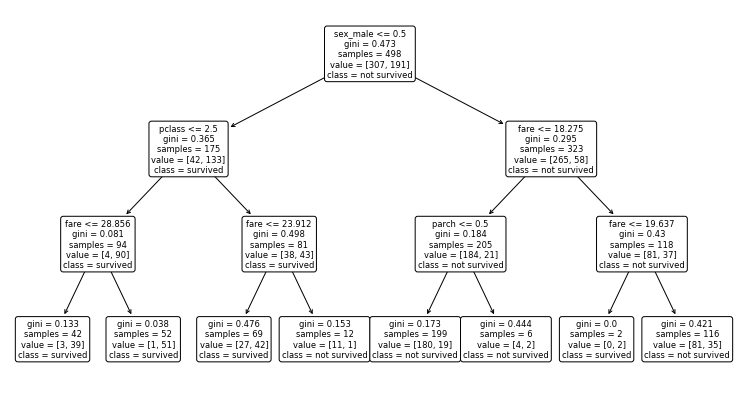

In [22]:
plt.figure(figsize=(13,7))
plot_tree(clf, feature_names=x_train.columns, class_names=['not survived', 'survived'], rounded = True)

In [23]:
# 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report

In [24]:
accuracy = clf.score(x_train, y_train)
y_pred = clf.predict(x_train)
conf = confusion_matrix(y_train, y_pred)
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.8233
The True Positive Rate is 0.702, The False Positive Rate is 0.101,
The True Negative Rate is 0.899, and the False Negative Rate is 0.298



,precision,recall,f1-score,support
0,0.828829,0.899023,0.862500,307.000000
1,0.812121,0.701571,0.752809,191.000000
accuracy,0.823293,0.823293,0.823293,0.823293
macro avg,0.820475,0.800297,0.807654,498.000000
weighted avg,0.822421,0.823293,0.820430,498.000000


In [25]:
y_pred = clf.predict(x_train)

In [26]:
y_pred_proba = clf.predict_proba(x_train)

In [27]:
clf.score(x_train, y_train)

0.8232931726907631

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred)

array([[276,  31],
       [ 57, 134]])

In [29]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [30]:
labels = sorted(y_train.unique())

In [31]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,276,31
1,57,134


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.81      0.70      0.75       191

    accuracy                           0.82       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498



In [33]:
# 4. Conpute accuracy, true positive rate, false positive rate, true negative reate, false negative rate, precision
# recall, f1-score, support
clf.score(x_validate, y_validate)

0.7850467289719626

In [34]:
y_pred = clf.predict(x_validate)

In [35]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       132
           1       0.76      0.65      0.70        82

    accuracy                           0.79       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.78      0.79      0.78       214



In [36]:
# 5. Repeat with a diff. max_depth

In [37]:
clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [38]:
clf = clf.fit(x_train, y_train)

[Text(607.8214285714286, 978.48, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]\nclass = not survived'),
 Text(318.85714285714283, 761.0400000000001, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]\nclass = survived'),
 Text(159.42857142857142, 543.6, 'fare <= 28.856\ngini = 0.081\nsamples = 94\nvalue = [4, 90]\nclass = survived'),
 Text(79.71428571428571, 326.1600000000001, 'fare <= 28.231\ngini = 0.133\nsamples = 42\nvalue = [3, 39]\nclass = survived'),
 Text(39.857142857142854, 108.72000000000003, 'gini = 0.093\nsamples = 41\nvalue = [2, 39]\nclass = survived'),
 Text(119.57142857142856, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = not survived'),
 Text(239.1428571428571, 326.1600000000001, 'parch <= 1.5\ngini = 0.038\nsamples = 52\nvalue = [1, 51]\nclass = survived'),
 Text(199.28571428571428, 108.72000000000003, 'gini = 0.0\nsamples = 48\nvalue = [0, 48]\nclass = survived'),
 Text(279.0, 108.72000000000003, 'gini = 0.375\n

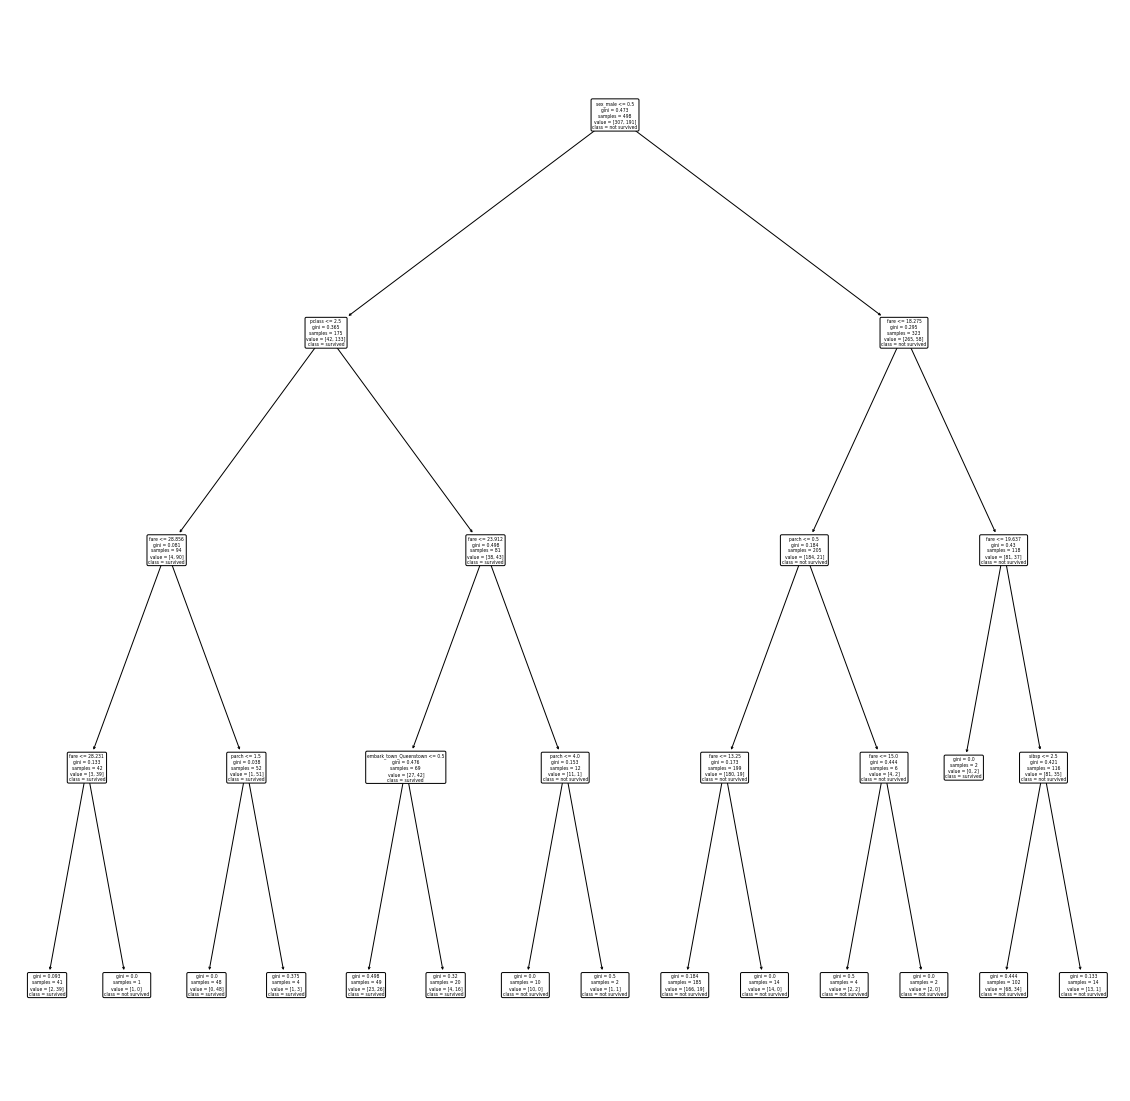

In [39]:
plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=x_train.columns, class_names=['not survived', 'survived'], rounded = True)

In [40]:
y_pred = clf.predict(x_train)

In [41]:
y_pred_proba = clf.predict_proba(x_train)

In [42]:
clf.score(x_train, y_train)

0.8253012048192772

In [43]:
confusion_matrix(y_train, y_pred)

array([[277,  30],
       [ 57, 134]])

In [44]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [45]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,277,30
1,57,134


In [46]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.82      0.70      0.75       191

    accuracy                           0.83       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.83      0.82       498



In [47]:
clf.score(x_validate, y_validate)

0.7850467289719626

In [48]:
y_pred = clf.predict(x_validate)

In [49]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       132
           1       0.76      0.65      0.70        82

    accuracy                           0.79       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.78      0.79      0.78       214



In [50]:
# 6. The larger max_depth performs better on the in sample (train) data
# 7. The larger max_depth performs better for the validate set as well. 

In [51]:
# from sklearn.tree import export_graphviz
# import graphviz

In [52]:
# dot_data = export_graphviz(clf, feature_names = x_train.columns, rounded=True, filled=True, out_file=None)
# graph = graphviz.Source(dot_data)

In [53]:
############################# Do these exercises using the telco dataset ########################################

In [54]:
telco = acquire.get_telco_data()

Using cached csv


In [55]:
telco = prepare.prep_telco(telco)

In [56]:
telco.head()

,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,65.6,593.30,0,1,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,59.9,542.40,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2,73.9,280.85,1,0,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,1,0
3,98.0,1237.85,1,1,0,1,0,0,0,0,...,1,1,1,1,0,0,0,0,1,0
4,83.9,267.40,0,1,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,0,1


In [57]:
# Locating the NaN values in df
is_nan = telco.isnull()
row_has_nan = is_nan.any(axis=1)
rows_with_nan = telco[row_has_nan]

In [58]:
telco.churn_Yes.value_counts()

0    5163
1    1869
Name: churn_Yes, dtype: int64

In [59]:
telco.isnull().values.any()

False

In [60]:
train, validate, test = train_validate_test_split(telco, 'churn_Yes', seed=123)

In [61]:
train.shape, validate.shape, test.shape

((3937, 29), (1688, 29), (1407, 29))

In [62]:
train['baseline'] = 0

In [63]:
accuracy_score(train.churn_Yes, train.baseline)

0.7343154686309372

In [64]:
train.drop(columns='baseline', inplace=True)

In [65]:
x_train = train.drop(columns='churn_Yes')
x_validate = validate.drop(columns='churn_Yes')
x_test = test.drop(columns='churn_Yes')

In [66]:
y_train = train.churn_Yes
y_validate = validate.churn_Yes
y_test = test.churn_Yes

In [67]:
clf = DecisionTreeClassifier(max_depth = 3, random_state=123)

In [68]:
clf = clf.fit(x_train, y_train)

[Text(502.20000000000005, 856.1700000000001, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.39\nsamples = 3937\nvalue = [2891, 1046]\nclass = no churn'),
 Text(251.10000000000002, 611.55, 'total_charges <= 237.275\ngini = 0.241\nsamples = 2215\nvalue = [1904, 311]\nclass = no churn'),
 Text(125.55000000000001, 366.93000000000006, 'streaming_movies_No internet service <= 0.5\ngini = 0.453\nsamples = 539\nvalue = [352, 187]\nclass = no churn'),
 Text(62.775000000000006, 122.30999999999995, 'gini = 0.5\nsamples = 263\nvalue = [129, 134]\nclass = churn'),
 Text(188.32500000000002, 122.30999999999995, 'gini = 0.31\nsamples = 276\nvalue = [223, 53]\nclass = no churn'),
 Text(376.65000000000003, 366.93000000000006, 'contract_type_Two year <= 0.5\ngini = 0.137\nsamples = 1676\nvalue = [1552, 124]\nclass = no churn'),
 Text(313.875, 122.30999999999995, 'gini = 0.203\nsamples = 985\nvalue = [872, 113]\nclass = no churn'),
 Text(439.42500000000007, 122.30999999999995, 'gini = 0.031\nsamples 

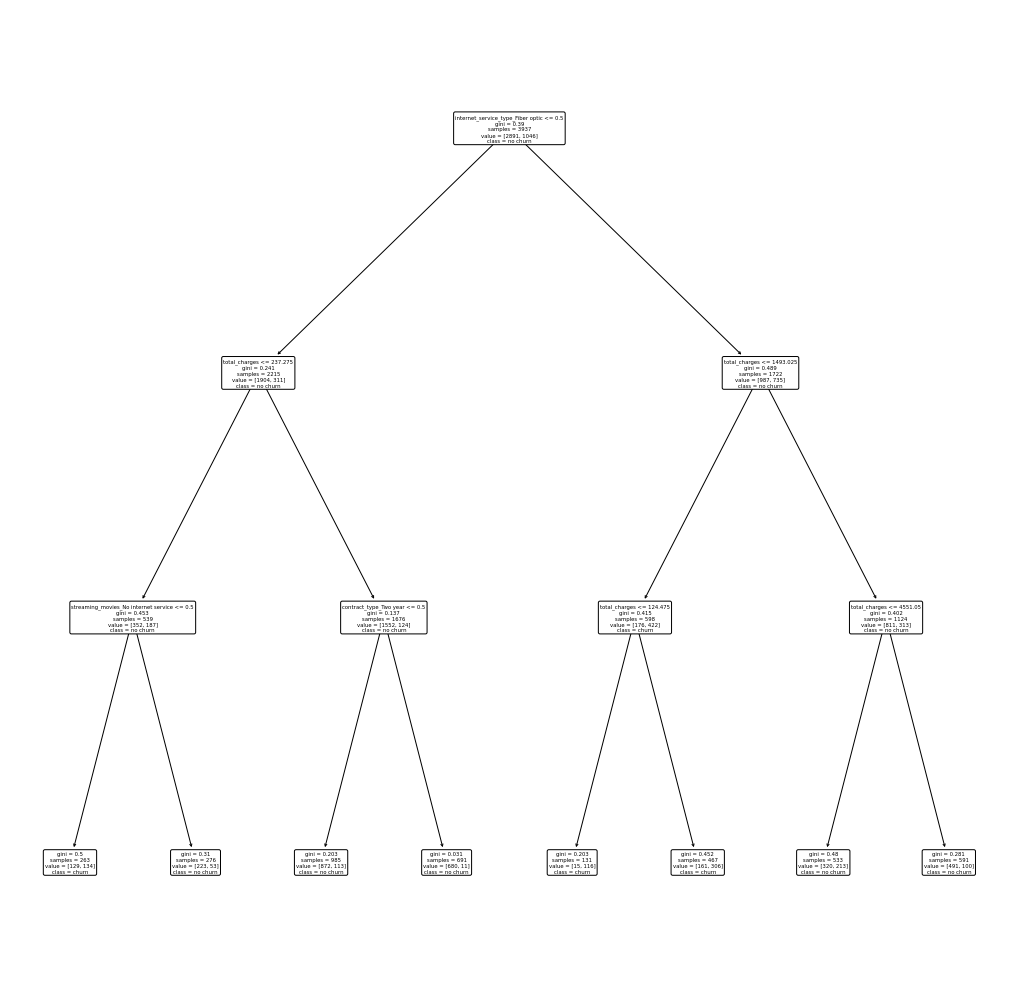

In [69]:
plt.figure(figsize=(18, 18))
plot_tree(clf, feature_names=x_train.columns, class_names=['no churn', 'churn'], rounded=True)

In [70]:
y_pred = clf.predict(x_train)

In [71]:
y_prep_proba = clf.predict_proba(x_train)

In [72]:
clf.score(x_train, y_train)

0.7980695961391923

In [73]:
confusion_matrix(y_train, y_pred)

array([[2586,  305],
       [ 490,  556]])

In [74]:
y_train.value_counts()

0    2891
1    1046
Name: churn_Yes, dtype: int64

In [75]:
labels = sorted(y_train.unique())
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,2586,305
1,490,556


In [76]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2891
           1       0.65      0.53      0.58      1046

    accuracy                           0.80      3937
   macro avg       0.74      0.71      0.72      3937
weighted avg       0.79      0.80      0.79      3937



In [77]:
clf.score(x_validate, y_validate)

0.7742890995260664

In [78]:
y_pred = clf.predict(x_validate)

In [79]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1239
           1       0.59      0.50      0.54       449

    accuracy                           0.77      1688
   macro avg       0.71      0.69      0.70      1688
weighted avg       0.76      0.77      0.77      1688



In [80]:
clf = DecisionTreeClassifier(max_depth = 2, random_state=123)

In [81]:
clf = clf.fit(x_train, y_train)

[Text(362.7, 317.09999999999997, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.39\nsamples = 3937\nvalue = [2891, 1046]\nclass = no churn'),
 Text(181.35, 190.26, 'total_charges <= 237.275\ngini = 0.241\nsamples = 2215\nvalue = [1904, 311]\nclass = no churn'),
 Text(90.675, 63.420000000000016, 'gini = 0.453\nsamples = 539\nvalue = [352, 187]\nclass = no churn'),
 Text(272.025, 63.420000000000016, 'gini = 0.137\nsamples = 1676\nvalue = [1552, 124]\nclass = no churn'),
 Text(544.05, 190.26, 'total_charges <= 1493.025\ngini = 0.489\nsamples = 1722\nvalue = [987, 735]\nclass = no churn'),
 Text(453.375, 63.420000000000016, 'gini = 0.415\nsamples = 598\nvalue = [176, 422]\nclass = churn'),
 Text(634.725, 63.420000000000016, 'gini = 0.402\nsamples = 1124\nvalue = [811, 313]\nclass = no churn')]

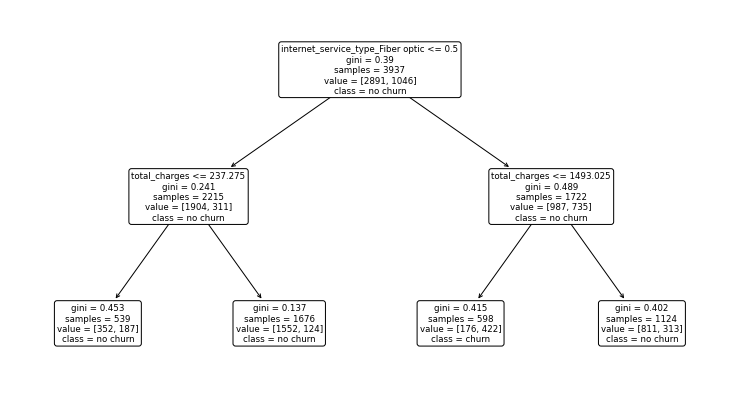

In [82]:
plt.figure(figsize=(13,7))
plot_tree(clf, feature_names = x_train.columns, class_names=['no churn', 'churn'], rounded = True)

In [83]:
y_pred = clf.predict(x_train)

In [84]:
clf.score(x_train, y_train)

0.7967995935991872

In [85]:
confusion_matrix(y_train, y_pred)

array([[2715,  176],
       [ 624,  422]])

In [86]:
y_train.value_counts()

0    2891
1    1046
Name: churn_Yes, dtype: int64

In [87]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,2715,176
1,624,422


In [88]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2891
           1       0.71      0.40      0.51      1046

    accuracy                           0.80      3937
   macro avg       0.76      0.67      0.69      3937
weighted avg       0.78      0.80      0.78      3937



In [89]:
clf.score(x_validate, y_validate)

0.7725118483412322

In [90]:
y_pred = clf.predict(x_validate)
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1239
           1       0.61      0.39      0.48       449

    accuracy                           0.77      1688
   macro avg       0.71      0.65      0.67      1688
weighted avg       0.75      0.77      0.75      1688



In [91]:
# There is not as much difference as I would've expected between the max_depth of 2 or 3 for this data. The larger
# max_depth still provides better results, but not by as much as I would have guessed. 

In [92]:
################################################################################################################

In [93]:
# Random Forest Exercise

In [94]:
# 1. Fit the Random Forest classifier to your training sample and tansform, setting random_state accordingly and 
# setting min_samples_leaf = 1 and max_depth = 10

In [95]:
from sklearn.ensemble import RandomForestClassifier

In [96]:
titanic = acquire.get_titanic_data()

Using cached csv


In [97]:
titanic = prepare.prep_titanic(titanic)

In [98]:
train, validate, test = train_validate_test_split(titanic, 'survived', seed=123)

In [99]:
train.shape, validate.shape, test.shape

((498, 9), (214, 9), (179, 9))

In [100]:
train['baseline'] = 0
accuracy_score(train.survived, train.baseline)
train.drop(columns='baseline', inplace=True)

In [101]:
x_train = train.drop(columns='survived')
y_train = train.survived

In [102]:
x_validate = validate.drop(columns='survived')
y_validate = validate.survived
x_test = test.drop(columns='survived')
y_test = test.survived

In [103]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, max_depth=10,
                           n_estimators=100, random_state=123)

In [104]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [105]:
print(rf.feature_importances_)

[0.10002143 0.06879504 0.05292745 0.3838233  0.02319394 0.32803056
 0.01522288 0.02798539]


In [106]:
y_pred = rf.predict(x_train)

In [107]:
y_pred_proba = rf.predict_proba(x_train)

In [108]:
rf.score(x_train, y_train)

0.9437751004016064

In [109]:
print(confusion_matrix(y_train, y_pred))

[[301   6]
 [ 22 169]]


In [110]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       307
           1       0.97      0.88      0.92       191

    accuracy                           0.94       498
   macro avg       0.95      0.93      0.94       498
weighted avg       0.94      0.94      0.94       498



In [111]:
rf.score(x_validate, y_validate)

0.7850467289719626

In [112]:
accuracy = rf.score(x_train, y_train)
y_pred = rf.predict(x_train)
conf = confusion_matrix(y_train, y_pred)
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.9438
The True Positive Rate is 0.885, The False Positive Rate is 0.0195,
The True Negative Rate is 0.98, and the False Negative Rate is 0.115



,precision,recall,f1-score,support
0,0.931889,0.980456,0.955556,307.000000
1,0.965714,0.884817,0.923497,191.000000
accuracy,0.943775,0.943775,0.943775,0.943775
macro avg,0.948801,0.932636,0.939526,498.000000
weighted avg,0.944862,0.943775,0.943260,498.000000


In [113]:
# 4. Repeat above steps using different min_samples_leaf and max_depth values

In [114]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=2, max_depth=8,
                           n_estimators=100, random_state=123)

In [115]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=2, random_state=123)

In [116]:
accuracy = rf.score(x_train, y_train)
y_pred = rf.predict(x_train)
conf = confusion_matrix(y_train, y_pred)
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.8876
The True Positive Rate is 0.764, The False Positive Rate is 0.0358,
The True Negative Rate is 0.964, and the False Negative Rate is 0.236



,precision,recall,f1-score,support
0,0.868035,0.964169,0.913580,307.00000
1,0.929936,0.764398,0.839080,191.00000
accuracy,0.887550,0.887550,0.887550,0.88755
macro avg,0.898986,0.864284,0.876330,498.00000
weighted avg,0.891776,0.887550,0.885007,498.00000


In [117]:
rf.score(x_validate, y_validate)

0.7990654205607477

In [118]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=3, max_depth=6,
                           n_estimators=100, random_state=123)

In [119]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=3, random_state=123)

In [120]:
accuracy = rf.score(x_train, y_train)
y_pred = rf.predict(x_train)
conf = confusion_matrix(y_train, y_pred)
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.8695
The True Positive Rate is 0.738, The False Positive Rate is 0.0489,
The True Negative Rate is 0.951, and the False Negative Rate is 0.262



,precision,recall,f1-score,support
0,0.853801,0.951140,0.899846,307.000000
1,0.903846,0.738220,0.812680,191.000000
accuracy,0.869478,0.869478,0.869478,0.869478
macro avg,0.878824,0.844680,0.856263,498.000000
weighted avg,0.872995,0.869478,0.866415,498.000000


In [121]:
rf.score(x_validate, y_validate)

0.8177570093457944

In [122]:
# It looks like the one with the highest max_depth and lowest min_sample_leaf performs the best in terms of metrics
# but I wonder to what degree this is just overfitting. 

In [123]:
#################################################         KNN Exercise

In [124]:
# 1. Fit a K-Nearest Neighbors classifier to your training sample and transform

In [125]:
titanic = acquire.get_titanic_data()

Using cached csv


In [126]:
titanic = prepare.prep_titanic(titanic)

In [128]:
from sklearn.neighbors import KNeighborsClassifier

In [129]:
titanic.head()

,survived,pclass,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,3,1,0,7.2500,0,1,0,1
1,1,1,1,0,71.2833,0,0,0,0
2,1,3,0,0,7.9250,1,0,0,1
3,1,1,1,0,53.1000,0,0,0,1
4,0,3,0,0,8.0500,1,1,0,1


In [130]:
titanic['baseline'] = 0

In [131]:
titanic.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [132]:
# Baseline accuracy for 'survival' target variable
accuracy_score(titanic.survived, titanic.baseline)

0.6161616161616161

In [134]:
titanic.drop(columns='baseline', inplace=True)

In [136]:
train, validate, test = train_validate_test_split(titanic, 'survived', seed=123)

In [137]:
train.shape, validate.shape, test.shape

((498, 9), (214, 9), (179, 9))

In [138]:
x_train = train.drop(columns='survived')
y_train = train.survived

In [139]:
x_validate = validate.drop(columns='survived')
y_validate = validate.survived
x_test = test.drop(columns='survived')
y_test = test.survived

In [141]:
# Create KNN object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [142]:
# Fit model to training data
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [143]:
y_pred = knn.predict(x_train)

In [144]:
y_pred_proba = knn.predict_proba(x_train)

In [145]:
knn.score(x_train, y_train)

0.8072289156626506

In [146]:
print(confusion_matrix(y_train, y_pred))

[[265  42]
 [ 54 137]]


In [147]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       307
           1       0.77      0.72      0.74       191

    accuracy                           0.81       498
   macro avg       0.80      0.79      0.79       498
weighted avg       0.81      0.81      0.81       498



In [148]:
knn.score(x_validate, y_validate)

0.7429906542056075

In [149]:
# Reports for the training set

accuracy = knn.score(x_train, y_train)
y_pred = knn.predict(x_train)
conf = confusion_matrix(y_train, y_pred)
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.8072
The True Positive Rate is 0.717, The False Positive Rate is 0.137,
The True Negative Rate is 0.863, and the False Negative Rate is 0.283



,precision,recall,f1-score,support
0,0.830721,0.863192,0.846645,307.000000
1,0.765363,0.717277,0.740541,191.000000
accuracy,0.807229,0.807229,0.807229,0.807229
macro avg,0.798042,0.790235,0.793593,498.000000
weighted avg,0.805654,0.807229,0.805951,498.000000


In [150]:
# Reports for validate set
y_pred = knn.predict(x_validate)

accuracy = knn.score(x_validate, y_validate)
y_pred = knn.predict(x_validate)
conf = confusion_matrix(y_validate, y_pred)
class_report = pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True)).T
conf = confusion_matrix(y_validate, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.743
The True Positive Rate is 0.622, The False Positive Rate is 0.182,
The True Negative Rate is 0.818, and the False Negative Rate is 0.378



,precision,recall,f1-score,support
0,0.776978,0.818182,0.797048,132.000000
1,0.680000,0.621951,0.649682,82.000000
accuracy,0.742991,0.742991,0.742991,0.742991
macro avg,0.728489,0.720067,0.723365,214.000000
weighted avg,0.739818,0.742991,0.740580,214.000000


In [151]:
# Do same with k=10

In [152]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')

In [153]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [154]:
y_pred = knn.predict(x_train)

In [155]:
# Reports for the training set

accuracy = knn.score(x_train, y_train)
y_pred = knn.predict(x_train)
conf = confusion_matrix(y_train, y_pred)
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.7831
The True Positive Rate is 0.644, The False Positive Rate is 0.13,
The True Negative Rate is 0.87, and the False Negative Rate is 0.356



,precision,recall,f1-score,support
0,0.797015,0.869707,0.831776,307.000000
1,0.754601,0.643979,0.694915,191.000000
accuracy,0.783133,0.783133,0.783133,0.783133
macro avg,0.775808,0.756843,0.763345,498.000000
weighted avg,0.780748,0.783133,0.779285,498.000000


In [156]:
y_pred = knn.predict(x_validate)

In [157]:
# Reports for validate set
y_pred = knn.predict(x_validate)

accuracy = knn.score(x_validate, y_validate)
y_pred = knn.predict(x_validate)
conf = confusion_matrix(y_validate, y_pred)
class_report = pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True)).T
conf = confusion_matrix(y_validate, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.715
The True Positive Rate is 0.561, The False Positive Rate is 0.189,
The True Negative Rate is 0.811, and the False Negative Rate is 0.439



,precision,recall,f1-score,support
0,0.748252,0.810606,0.778182,132.000000
1,0.647887,0.560976,0.601307,82.000000
accuracy,0.714953,0.714953,0.714953,0.714953
macro avg,0.698070,0.685791,0.689745,214.000000
weighted avg,0.709794,0.714953,0.710407,214.000000


In [158]:
# k = 20

In [160]:
knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')

In [161]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [162]:
y_pred = knn.predict(x_train)

In [163]:
# Reports for the training set

accuracy = knn.score(x_train, y_train)
y_pred = knn.predict(x_train)
conf = confusion_matrix(y_train, y_pred)
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
conf = confusion_matrix(y_train, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.7369
The True Positive Rate is 0.545, The False Positive Rate is 0.143,
The True Negative Rate is 0.857, and the False Negative Rate is 0.455



,precision,recall,f1-score,support
0,0.751429,0.856678,0.800609,307.000000
1,0.702703,0.544503,0.613569,191.000000
accuracy,0.736948,0.736948,0.736948,0.736948
macro avg,0.727066,0.700590,0.707089,498.000000
weighted avg,0.732741,0.736948,0.728873,498.000000


In [164]:
y_pred = knn.predict(x_validate)

In [165]:
# Reports for validate set

accuracy = knn.score(x_validate, y_validate)
y_pred = knn.predict(x_validate)
conf = confusion_matrix(y_validate, y_pred)
class_report = pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True)).T
conf = confusion_matrix(y_validate, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy: .4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is  0.6729
The True Positive Rate is 0.463, The False Positive Rate is 0.197,
The True Negative Rate is 0.803, and the False Negative Rate is 0.537



,precision,recall,f1-score,support
0,0.706667,0.803030,0.751773,132.000000
1,0.593750,0.463415,0.520548,82.000000
accuracy,0.672897,0.672897,0.672897,0.672897
macro avg,0.650208,0.633222,0.636160,214.000000
weighted avg,0.663400,0.672897,0.663173,214.000000


In [166]:
# The metrics go down as the number of neighbors increases. This seems to be the case for the in-sample and 
# out-of-sample datasets, but it appears to be relatively consistent in drop for both.